In [35]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

print(torch.cuda.is_available())
print(torch.accelerator.current_accelerator())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True
cuda


device(type='cuda')

In [19]:
import torchvision

training_data = torchvision.datasets.MNIST(root="data",
                                            train=True,
                                           download=True,
                                           transform=torchvision.transforms.ToTensor())

testing_data = torchvision.datasets.MNIST(root="data",
                                          train=False,
                                          download=True,
                                          transform=torchvision.transforms.ToTensor())

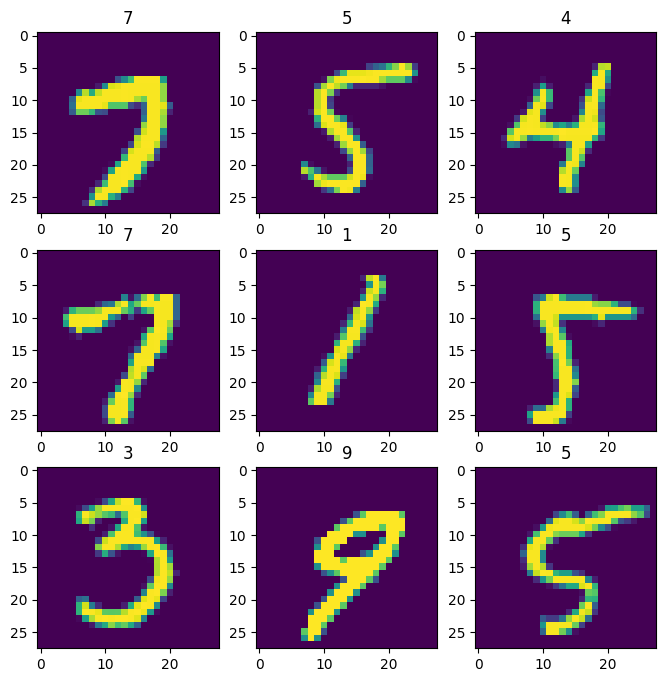

In [20]:
# from matplotlib import pyplot as plt
# sample_training_images = training_data
from matplotlib import pyplot as plt
import random

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
  sample_idx = random.randint(1, len(training_data))
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.imshow(img.squeeze())
plt.show()

### Preparing your data for training with DataLoaders

The `Dataset` retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s `multiprocessing` to speed up data retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an easy API.

### Iterate through the DataLoader

We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled 

tensor([1, 7, 7, 6, 3, 2, 9, 1, 5, 8, 7, 2, 4, 7, 3, 6, 5, 7, 0, 7, 2, 9, 1, 7,
        5, 3, 3, 3, 5, 4, 0, 0, 9, 9, 8, 2, 8, 9, 3, 0, 8, 7, 8, 6, 0, 3, 7, 2,
        4, 1, 0, 5, 7, 2, 7, 9, 7, 8, 7, 2, 6, 0, 2, 6])

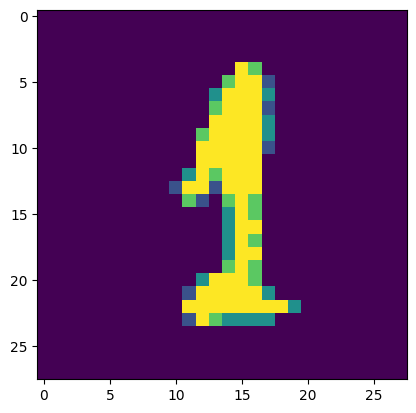

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))

plt.imshow(train_features[0].squeeze())
train_labels

In [22]:
def reset_weights(model):
  if isinstance(model, nn.Linear) or isinstance(model, nn.Conv2d):
    model.reset_parameters()

In [23]:


class NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28 * 28, 512)  # 28x28 pixels
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 10)    # 10 classes
    
  def forward(self, x):
    x = nn.Flatten(start_dim=1, end_dim=-1)(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

  def reset(self):
    self.apply(reset_weights)

model = NN().to(device)


In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
torch.cuda.empty_cache()
model.reset()
optimizer.zero_grad()

In [46]:
epochs = 20
y_plot = []
for epoch in range(epochs):
  model.train()
  total_loss = 0
  for batch in train_dataloader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    output = model(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  y_plot.append(total_loss)
  print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/20, Loss: 173.0082
Epoch 2/20, Loss: 65.0474
Epoch 3/20, Loss: 43.0891
Epoch 4/20, Loss: 31.1883
Epoch 5/20, Loss: 25.1221
Epoch 6/20, Loss: 19.3923
Epoch 7/20, Loss: 19.1762
Epoch 8/20, Loss: 14.2067
Epoch 9/20, Loss: 12.6661
Epoch 10/20, Loss: 11.8668
Epoch 11/20, Loss: 12.1745
Epoch 12/20, Loss: 11.3429
Epoch 13/20, Loss: 11.0482
Epoch 14/20, Loss: 8.5424
Epoch 15/20, Loss: 9.6662
Epoch 16/20, Loss: 12.0843
Epoch 17/20, Loss: 7.9094
Epoch 18/20, Loss: 6.2544
Epoch 19/20, Loss: 7.7646
Epoch 20/20, Loss: 9.7650


Text(0.5, 1.0, 'epoch vs loss')

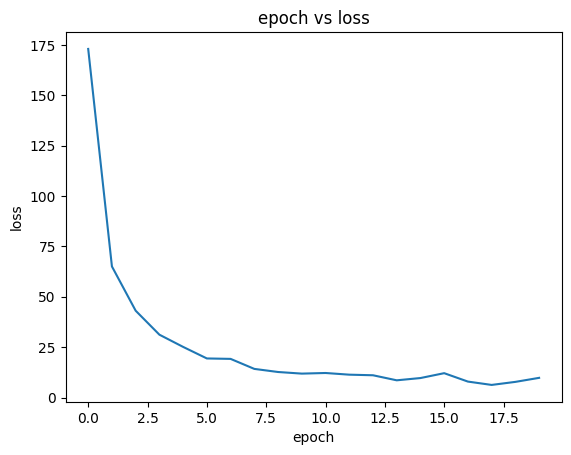

In [ ]:
x_plot = np.arange(0, epochs, 1)
plt.plot(x_plot, y_plot)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("epoch vs loss")

### 🧮 1. Define Loss and Optimizer

```python
loss_fn = nn.CrossEntropyLoss()
```

-   This is your **criterion** — the function that tells you **how wrong your predictions are**.
    
-   `CrossEntropyLoss` is **used for classification problems** (like MNIST).
    
-   It combines:
    
    -   `LogSoftmax` → turns logits into log probabilities
        
    -   `Negative Log-Likelihood` → penalizes wrong predictions more
        

```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
```

-   `Adam` is your optimizer — your **gradient descent engine**.
    
-   It adjusts the model weights **based on the loss gradients**.
    
-   `model.parameters()` → gives all the model's weights & biases
    
-   `lr=0.001` is the **learning rate** — how fast the model updates itself
    

---

### 🔁 2. Loop Through Epochs

```python
epochs = 20
for epoch in range(epochs):
```

-   An **epoch** is one complete pass over the **entire training dataset**
    
-   You’ll do this **20 times**
    

---

### ⚙️ 3. Set Training Mode

```python
model.train()
```

-   Sets the model in **training mode**
    
-   Turns ON:
    
    -   `Dropout`
        
    -   Batch statistics for `BatchNorm`
        

If you don’t call this → your model might behave like it’s testing (`.eval()` mode).

---

### 💰 4. Track Epoch Loss

```python
total_loss = 0
```

-   We'll accumulate loss here to **monitor training progress**
    

---

### 📦 5. Loop Over Batches

```python
for batch in train_dataloader:
    images, labels = batch
```

-   `train_dataloader` yields batches of images and labels.
    
-   Let’s say batch size = 64 → each batch has 64 handwritten digits and their labels
    

---

### 🖼️ 6. Move Data to GPU (if available)

```python
images, labels = images.to(device), labels.to(device)
```

-   Ensures both input and target are on the **same device** (`cpu` or `cuda`)
    
-   `device` was probably set earlier like:
    
    ```python
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ```
    

---

### 🧹 7. Zero Out Gradients

```python
optimizer.zero_grad()
```

-   Clears out old gradients from the **previous batch**
    
-   Think of it like cleaning your whiteboard before solving the next question
    

---

### 📤 8. Forward Pass

```python
output = model(images)
```

-   This feeds images through the model
    
-   Output: **raw logits** (not probabilities yet)
    

---

### 📉 9. Compute Loss

```python
loss = loss_fn(output, labels)
```

-   Compares model’s predictions (`output`) with ground truth (`labels`)
    
-   Returns a **single number** — the loss
    

---

### 🧬 10. Backpropagation

```python
loss.backward()
```

-   Computes gradients of loss w.r.t **each model parameter**
    
-   This is where the magic happens — the model **learns where it messed up**
    

---

### 🛠️ 11. Update Weights

```python
optimizer.step()
```

-   Uses gradients to **adjust the weights**
    
-   So next time the model predicts **closer to the truth**
    

---

### 🧾 12. Accumulate Loss

```python
total_loss += loss.item()
```

-   `.item()` turns a 1-element tensor into a regular Python float
    
-   Useful for logging and printing
    

---

### 📢 13. Print Progress

```python
print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
```

-   Gives you feedback on how the model is learning over time
    
-   Lower loss = better model (hopefully)
    

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.94%


In [ ]:
# fc1_w = model.fc1.weight.detach().cpu()
# fc1_b = model.fc2.bias.detach().cpu()

